In [1]:
# Trying a DenseNet
# Based off DenseNet-121 in Table 1,
# Densely Connected CNNs, Huang et. al.

# Use CIFAR-10 image database
import torch
import torchvision
import torchvision.transforms as transforms

# Normalize image pixel values from range [0, 1] to range [-1, 1]
# (from tutorial)
# TODO: normalize by channel mean and standard dev.
#       - can use torch.mean(input, 0) to get mean value of each channel,
#         and torch.std(input, 0) to get stand. dev. of each channel
#         (make sure 0 is the right dimension)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True,
                                          num_workers=4)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False,
                                         num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


  dog   cat  frog truck


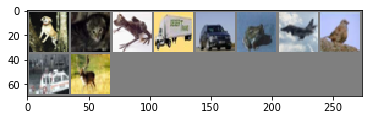

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# function to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #axes 1, 2, 0

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images with labels
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# TODO: fix so only 4 images show


In [ ]:
# Create the DenseNet

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class DenseNetTest(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # (in_channels, out_channels, kernel size, stride)
        self.conv1 = nn.Conv2d(3, 16, 7, stride=2)



